In [1]:
!pip install --user faker

In [2]:
from PIL import Image, ImageOps, ImageFilter, ImageChops
from IPython import display
import random

IMG = Image.open('./judgement2.jpg')

def random_image(img=IMG, size=(200, 100)):
    width, height = size
    sqrt2 = 2 ** .5
    regionsize = int(min(
        max(width, height) * sqrt2,
        min(img.size),
    ))
    inscribed = int(regionsize / sqrt2)
    x = random.randint(0, img.width - regionsize)
    y = random.randint(0, img.height - regionsize)
    subsection = img.crop([x, y, x+regionsize, y+regionsize])
    angle = random.randint(0, 360)
    rotated = subsection.rotate(angle)
    cropbox = [
    ]
    ratio = width / height
    if ratio > 1:
        cw, ch = inscribed, inscribed / ratio 
    else:
        cw, ch = inscribed * ratio, inscribed
    cropbox = (
        (regionsize-cw)/2, 
        (regionsize-ch)/2,
        (regionsize+cw)/2,
        (regionsize+ch)/2,
    )
    cropped = rotated.crop(cropbox)
    blur = ImageFilter.GaussianBlur(1)
    result = cropped.resize((width, height))
    enhanced = result.filter(blur)
    enhanced = random_bands(enhanced)
    blended = ImageChops.blend(result, enhanced, 0.5)
    blended = ImageChops.blend(blended, ImageOps.equalize(blended), 0.5)
    blended = blended.filter(blur)
    #blended =  ImageOps.equalize(blended)
    return blended 

def random_bands(img):
    r,g,b = img.split()
    bands = [r,g,b]
    dice = [True] * 2 + [False] * 3 
    random.shuffle(dice)
    if dice.pop():
        random.shuffle(bands)
    negbands = (ImageChops.invert(b) for b in bands)
    bands = [n if d else b for (b, n, d) in zip(bands, negbands, dice)]
    newimg = Image.merge('RGB', bands)
    newimg = ImageOps.equalize(newimg)
    return newimg



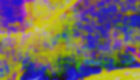
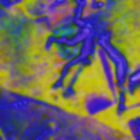
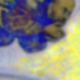
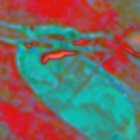
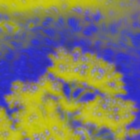
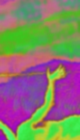
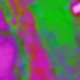
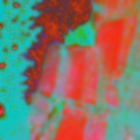
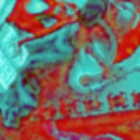
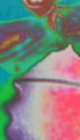
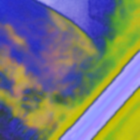
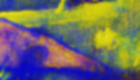
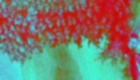
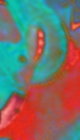
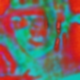
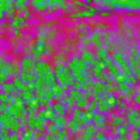
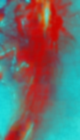
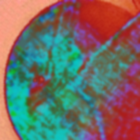
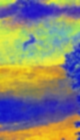
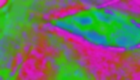
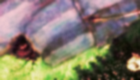
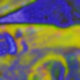
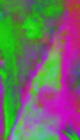
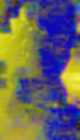
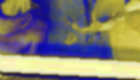
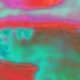
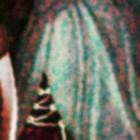
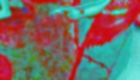
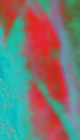
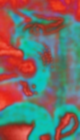
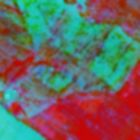
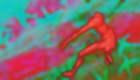
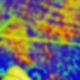
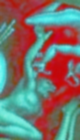
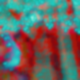
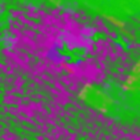
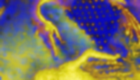
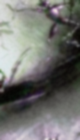
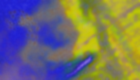
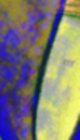
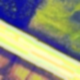
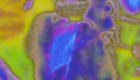
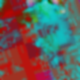
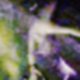
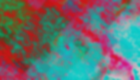
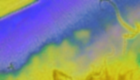
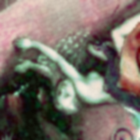
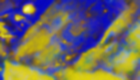
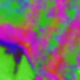
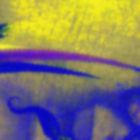

In [3]:
from io import BytesIO
import base64

def data_url(image):
    b = BytesIO()
    image.convert('RGB').save(b, 'PNG')
    raw = b.getvalue()
    data = base64.encodebytes(raw).decode('ascii').replace('\n', '')
    return 'data:image/png/;base64,{}'.format(data)

def image_to_html_img(image, style={}, **attrs):
    attrs['style'] = '{}'.format(';'.join('{}: {}'.format(*item) for item in style.items()))
    attrs['src'] = data_url(image)
    html = '<img {} />'.format(' '.join('{}="{}"'.format(*item) for item in attrs.items()))
    return html

def make_images(n=1, in_range=range(200,500,100)):
    choice = lambda: random.choice(in_range)
    images = (random_image(size=(choice(), choice())) for _ in range(n))
    style = {'display': 'inline-block', 'margin': '2px'}
    html = ''.join(image_to_html_img(img, style, title=img.size) for img in images)
    return display.HTML(html)

make_images(50, range(80, 200, 60))

In [9]:
from django.core.files import File
from faker import Factory
FAKE = Factory.create('no')

def fake_imagefile(size=(1200, 600), class_=ImageFile, fake=FAKE, **kwargs):
    image = random_image(size=size)
    blob = BytesIO()
    image.convert('RGB').save(blob, 'JPEG')
    filename = kwargs.pop('filename', fake.file_name(extension='jpg'))
    instance = class_(**kwargs)
    content = File(blob)
    instance.source_file.save(filename, content)
    return instance

def fake_contributor(fake=FAKE, **kwargs):
    name = fake.name()
    filename = '{}.jpg'.format(name).lower()
    byline_photo = fake_imagefile((400,400), ProfileImage, filename=filename)
    instance = Contributor(
        byline_photo = byline_photo,
        display_name = name,
        phone = fake.phone_number(),
        email = fake.email(),
        verified = True,
    )
    instance.save()
    return instance

In [10]:
def fake_story_image(story, byline):
    imagefile = fake_imagefile(contributor=byline)
    instance = StoryImage(
        parent_story = story,
        caption = 'foobar',
        imagefile = imagefile,
    )
    instance.save()
    return instance

In [11]:
def random_contributor():
    try:
        return Contributor.objects.order_by('?').first()
    except Contributor.DoesNotExist:
        fake_contributor()

def random_storytype():
    return StoryType.objects.order_by('?').first()

def fake_story_content(fake=FAKE):
    sections = "@tit:{title}", "@ing:{lede}", "@txt:{content}"
    title = fake.sentence(random.choice([1,2,3]))
    lede = ' '.join(fake.sentences(random.choice([1,2,3])))
    content = '\n'.join(fake.paragraphs(random.choice([4,5,10,20,30])))
    return '\n'.join(sections).format(title=title, lede=lede, content=content)


def fake_story():
    photo_by = random_contributor()
    text_by = random_contributor()
    markup = '{}\n@bl: text: {}\n@bl: photo:{}'.format(
        fake_story_content(), text_by, photo_by)
    
    print(markup)
    
    story = Story(
        story_type=random_storytype(),
        bodytext_markup=markup,
        publication_status = Story.STATUS_PUBLISHED,
        publication_date = timezone.now(),
    )
    story.save()
    numphotos = random.choice([0,1,1,3,5])
    for _ in range(numphotos):
        fake_story_image(story, photo_by)
    story.refresh_from_db()
    story.full_clean()
    story.frontpagestory_set.all().delete()
    story.save(new=True)
    return story

fake_story()

17:20:12 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



@tit:Provident.
@ing:Quas error necessitatibus ab. Ad provident et error sequi officia sunt excepturi. Maiores temporibus corrupti voluptate amet.
@txt:Quasi fuga quia eum nostrum enim nostrum. Quam tempore nemo et. Hic placeat dolor sit. Quos iure est laboriosam mollitia quibusdam rerum ratione.
Dolores reprehenderit earum porro beatae quisquam laboriosam sint. Animi temporibus debitis facilis aliquid fuga corporis. Laboriosam velit harum laudantium accusantium aliquam hic.
Saepe nam veritatis sint ullam. Quaerat assumenda aspernatur harum deleniti reiciendis blanditiis similique facilis. Amet atque expedita assumenda qui nisi officiis ut reprehenderit. Est earum possimus repudiandae iste assumenda.
Labore enim voluptate id assumenda ducimus tempore. Ipsum quia officia suscipit perspiciatis occaecati.
@bl: text: Sigurd Haug-Hagen
@bl: photo:Odd Iversen


17:20:13 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



<Story: 2017-02-06: Provident.>

In [12]:
Story.objects.all().delete()
Contributor.objects.all().delete()
[print(fake_contributor()) for n in range(20)]
[print(fake_story()) for n in range(20)]
print('foo')

Trond Myhre
Mona Knutsen
Kåre Danielsen
Arild Myhre
Andrea Lunde
Simen Rønning
Sigurd-Hans Moen
Kirsten Kristoffersen
Svein Haugland-Aas
Mari Jakobsen
Prof. Jens Nguyen
Egil Knudsen-Ahmed
Unni Myklebust
Harald Madsen
Sofie Sørensen
Irene-Ellen Andreassen
Karoline Eliassen
Irene Nygård
Else Myklebust
Tonje Haug
@tit:Doloribus rem.
@ing:Maiores itaque laboriosam esse deleniti ut id doloremque eum. Consectetur quod enim odio cumque ipsum. Praesentium necessitatibus sint dolorum modi error eos quasi hic.
@txt:Tenetur aliquam labore tempore necessitatibus excepturi. Veritatis quibusdam consequatur dolor hic omnis eos id. Labore aspernatur reiciendis ipsa ipsa. Consectetur consequatur illo exercitationem id iusto blanditiis.
Ipsa a inventore pariatur quisquam. Autem numquam error nobis voluptates unde magnam ipsam iste. Quidem ut sunt cum sapiente sunt autem voluptatibus rerum.
Autem molestias fugit assumenda quas voluptatem. Non illo assumenda velit placeat. Praesentium beatae ab perspiciat

17:20:22 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

17:20:22 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-06: Doloribus rem.
@tit:Expedita.
@ing:Perspiciatis sint cupiditate dolor quidem fugit.
@txt:Facere ipsa tenetur neque voluptatum sequi. Nobis voluptatem beatae molestiae aliquid dolores nihil officia dicta. Quis a natus recusandae. Explicabo omnis similique blanditiis magnam nam aperiam.
Nobis aspernatur et cum exercitationem distinctio ab. Nisi ea ipsam error dicta odio. Praesentium quam assumenda aut fugit veritatis.
Esse omnis repellat ea odit sequi. Culpa tempora maiores cumque sunt dolores nihil deserunt. Distinctio corrupti qui officiis soluta laudantium illum.
Laboriosam molestias fugiat iusto unde tenetur laboriosam. Sequi modi delectus numquam tempora. Possimus earum quis mollitia officiis iusto libero itaque. Voluptatem ducimus distinctio aliquid porro ipsum autem. Quibusdam rem sit ratione consequatur voluptates.
Eius ullam dicta nisi. Eveniet laudantium numquam quisquam beatae necessitatibus exercitationem. Dolorem aliquid quam sunt ipsa.
@bl: text: Prof. Jens Nguy

17:20:23 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

17:20:24 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

17:20:24 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)



2017-02-06: Expedita.
@tit:Fugit nobis nam nesciunt.
@ing:Accusantium repellat laborum sed distinctio assumenda quisquam. Id sed atque animi incidunt temporibus ullam distinctio.
@txt:Voluptatem nulla est porro odit ab. Expedita asperiores pariatur esse dolorum voluptatum adipisci porro.
Ex maiores dolorum occaecati hic ea facilis praesentium fugit. Non fuga minus tempora fugiat dolorem. Architecto placeat tempore voluptates ratione nisi. Ab quam recusandae cumque maiores voluptas.
Temporibus delectus sit eius debitis deleniti. Ea magnam aut quaerat sapiente expedita. Consectetur tenetur explicabo corrupti nulla error sapiente tenetur. Soluta non praesentium cupiditate consectetur fugiat.
Aliquam ratione minus praesentium. Ducimus voluptas vitae autem a aperiam. Similique fuga architecto esse similique. Consequuntur quod dolore ipsam debitis laborum.
Corrupti voluptatum possimus at laboriosam tempore magnam. In error quod repudiandae tenetur quasi. Earum molestias modi dicta officia of

17:20:24 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

17:20:24 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-06: Fugit nobis nam nesciunt.
@tit:Accusamus occaecati quaerat.
@ing:Maxime delectus quia dolorum soluta eos. Dolorem autem soluta blanditiis architecto cum quibusdam recusandae.
@txt:Culpa nesciunt vero aut amet. Ex inventore dignissimos dolore doloribus cumque earum. Maiores reiciendis delectus labore iusto sunt minus quasi.
Neque nihil aperiam accusamus nesciunt nihil repudiandae repellendus deleniti. Repellendus ut ipsam nemo similique nemo eveniet. Rerum amet corporis ipsam cumque quos accusantium aut. Commodi quisquam neque eveniet occaecati.
Fugiat numquam cupiditate quia molestiae laudantium. Quibusdam voluptatum reiciendis aliquam maiores eveniet saepe adipisci. Deleniti iste velit illum alias suscipit. Quaerat perferendis repellat modi laborum. Nesciunt adipisci autem earum quisquam illo.
Enim voluptas voluptate impedit assumenda eos. Placeat dolorum nobis repellat eius. Ipsum repellat atque sapiente minus deleniti esse.
Quasi fugiat voluptates aspernatur nam. Quo del

17:20:25 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

17:20:26 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-06: Accusamus occaecati quaerat.
@tit:Quis non.
@ing:Soluta tempora nobis mollitia deserunt quibusdam. Quibusdam vitae doloribus eveniet dolores.
@txt:Animi beatae veritatis odio odit itaque voluptates. Dolore eum aut perferendis dolores aperiam culpa aliquid neque. Dicta neque expedita explicabo eum reiciendis. Quas provident veritatis qui ullam.
Modi adipisci voluptatem dolores minima. Officiis eligendi quasi iste animi adipisci at. Temporibus ullam hic quod.
Placeat praesentium unde exercitationem labore dolore saepe harum. Ipsam expedita molestias dolorem corrupti quos velit sit quod. Maiores expedita adipisci nam quo quidem quidem. Exercitationem animi natus fugiat consectetur perferendis.
Asperiores tempore autem adipisci laborum praesentium accusamus libero. Sit corporis odit sint iusto temporibus accusantium. Voluptate at porro dicta iure temporibus.
Delectus architecto ea quas sit. Neque iste sequi maxime. Cum ullam voluptates at sint quos. Pariatur nesciunt facere dol

17:20:26 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 2)

17:20:26 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(4, 1)



2017-02-06: Quis non.
@tit:Blanditiis itaque.
@ing:Consectetur necessitatibus facere assumenda aspernatur blanditiis qui molestias. Placeat itaque enim cupiditate excepturi dolorum fugiat tenetur mollitia. Nemo ipsa sint quasi in ipsum praesentium.
@txt:Pariatur hic quis expedita quibusdam et dolorum sint. Ut iste possimus perspiciatis quam consequuntur. Debitis beatae cumque necessitatibus tempore sit itaque. Nam perferendis quae deleniti maxime quia enim.
Perspiciatis quidem tempore quasi quod temporibus nemo. Veniam nesciunt dolor fuga ducimus deleniti ad. Perspiciatis illum voluptas corrupti dignissimos.
Harum id ipsum in commodi architecto fuga quae. Nemo omnis omnis nesciunt quidem.
Tenetur architecto optio numquam autem. Earum laudantium cum occaecati voluptatem dolore tenetur aliquid pariatur. Debitis fuga doloribus tempora molestiae.
Porro perspiciatis eius ipsam totam eum velit. In corporis id dolorem doloribus veniam accusamus dignissimos. Numquam blanditiis necessitatibus d

17:20:26 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

17:20:26 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-06: Blanditiis itaque.
@tit:Laboriosam sed itaque.
@ing:Commodi laboriosam nesciunt reiciendis repudiandae maiores. Facilis expedita mollitia ea officiis sunt. Dolore veritatis at dolorem eligendi quisquam.
@txt:Inventore consequuntur perferendis dicta quia vel minus tempora. Illo laboriosam vero laborum praesentium eum quibusdam. Occaecati incidunt cupiditate a accusantium dolorum ullam. Deserunt dolor magni quidem consequatur maiores facere labore incidunt. Dolore eos voluptate cumque amet nam rem autem.
Architecto amet et magni inventore corrupti minima ullam id. Ea dolores beatae minima assumenda aut sit. Fuga dolor tempore sint sint dolor. Voluptates quos repellendus asperiores dolorum ab.
Illum sapiente recusandae sunt amet sunt dolor. Dolores fuga laudantium eum corrupti illum sapiente. Culpa tenetur ducimus incidunt excepturi culpa harum.
Quod expedita voluptatibus delectus rerum reprehenderit laboriosam. Iste accusamus facilis voluptatibus vero provident iste praesenti

17:20:27 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

17:20:27 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-06: Laboriosam sed itaque.
@tit:Mollitia a praesentium.
@ing:Sint deleniti aliquam illo quam.
@txt:Unde impedit repellendus unde. Quasi nam expedita sint sed. Quisquam rerum qui cupiditate dignissimos nisi fuga. Maiores quo aspernatur voluptatem ratione.
Incidunt saepe corrupti quisquam aspernatur velit. Perferendis neque beatae est enim optio placeat a. Illo voluptates architecto architecto vel optio voluptas. Praesentium corporis nesciunt exercitationem doloribus unde. Perferendis sunt voluptate dicta quae.
Exercitationem doloremque officiis architecto molestiae aliquam voluptates. Maiores perspiciatis voluptas dolore possimus nobis in. Expedita omnis ipsa laboriosam voluptatum sint saepe similique.
Omnis at hic porro. Ducimus magni amet voluptatibus esse. Sit quisquam quo repellendus ea.
@bl: text: Sofie Sørensen
@bl: photo:Tonje Haug


17:20:29 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-06: Mollitia a praesentium.
@tit:Eligendi voluptas possimus.
@ing:Esse iusto ex et distinctio. Atque tempora minima sapiente aspernatur iure occaecati. Aperiam officia voluptates optio ea.
@txt:Incidunt ullam vitae earum earum commodi porro. Sed iste unde blanditiis porro. Veniam iure pariatur praesentium fuga. Necessitatibus est dolore earum fugit debitis dolorum.
Excepturi reprehenderit maiores itaque. Hic consequatur et ad ad. Expedita sed mollitia aspernatur. Quos est beatae doloribus debitis. Nostrum quisquam iure atque impedit sapiente.
Omnis molestias optio nobis eaque. Aperiam nihil earum alias officia. Cum amet rem aperiam excepturi sapiente necessitatibus. Ea suscipit magnam labore dolorum molestias quas modi. Magni sit sed et delectus tempora.
Tempora porro veritatis ratione eos. Accusantium cupiditate cumque magnam accusantium doloremque iusto. Quas iste quis delectus. Facilis earum ea saepe quod.
Fugiat dolorem sit hic atque hic distinctio delectus. Occaecati quod 

17:20:29 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)

17:20:29 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

17:20:29 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-06: Eligendi voluptas possimus.
@tit:Amet ipsam molestiae.
@ing:Quaerat sit similique suscipit ducimus cupiditate quas vero doloribus. Expedita minima cumque error illum voluptatem culpa.
@txt:Culpa asperiores perferendis unde corporis laudantium dolorum atque possimus. Consequuntur ducimus similique cum libero praesentium accusantium. Dolor temporibus culpa sunt quam error reprehenderit laborum.
Quae nulla consequuntur ut dignissimos repellat eum aspernatur. Vitae voluptatibus eligendi asperiores hic. Vel saepe corrupti numquam dicta.
Voluptatum cupiditate fuga veritatis accusantium cupiditate labore. Nulla illo ducimus dicta dolorem. Temporibus omnis adipisci amet et quasi vitae autem.
Adipisci neque ad cupiditate. Nulla beatae dolores ut. Reprehenderit hic iusto hic assumenda facere. Tempora deleniti blanditiis at adipisci alias repudiandae.
@bl: text: Sofie Sørensen
@bl: photo:Irene-Ellen Andreassen


17:20:30 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

17:20:30 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-06: Amet ipsam molestiae.
@tit:Veritatis iure.
@ing:Veniam sapiente doloribus omnis soluta.
@txt:Explicabo doloribus voluptatum magnam accusamus nobis. Maiores magni ex velit quas soluta. Aliquid blanditiis non vel vitae reprehenderit beatae.
Repellendus enim amet a provident aperiam dicta et. Qui consequuntur soluta autem aperiam amet excepturi eligendi. Eius dolorum quas facere amet. A aliquam neque voluptatum a ipsum delectus labore id.
Tenetur odit minima perferendis odio blanditiis consequatur. Nihil ipsa sapiente omnis illo. Necessitatibus beatae totam eveniet omnis quo dolores repellendus. Quia temporibus sint aperiam vero debitis nulla culpa.
Quibusdam numquam pariatur fugiat eveniet. Mollitia dicta similique perferendis voluptatibus veniam. Maxime veniam consequuntur aliquam facere.
Eaque incidunt qui numquam. Earum fugiat consequatur delectus optio. Eum facere unde consequuntur perferendis vitae rerum est. Soluta quis vero excepturi quod magni nemo optio.
Ullam quo qu

17:20:30 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:2 size:(3, 2)

17:20:30 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-06: Veritatis iure.
@tit:Molestiae.
@ing:Minima cum quod dolore similique quo. Facere nostrum error quasi delectus molestiae.
@txt:Blanditiis rem commodi reprehenderit molestias laborum corrupti maiores ullam. Odit odio vero dolorem dolores iure. Officiis nesciunt quae vel explicabo ipsum.
Fugit dignissimos modi dicta consequuntur aut porro. Voluptas id provident aut quasi commodi.
Aliquid voluptatum a itaque sapiente excepturi. Fugiat officiis dignissimos perspiciatis cupiditate. Deleniti vel blanditiis non. Quisquam molestiae facere laudantium quos molestias ipsum unde.
Quia cumque quibusdam omnis vitae dolores accusantium. Optio dolor ad esse quo aspernatur ab ex. Omnis necessitatibus voluptatem facere nobis.
Ratione hic deserunt provident quaerat molestias quam ratione. Quae itaque porro porro tenetur odit placeat cumque. Quaerat cupiditate laudantium fuga incidunt. Corrupti quam qui eligendi est quibusdam vero voluptatum.
Dignissimos quis magnam labore architecto magnam am

17:20:31 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-06: Molestiae.
@tit:Ipsam blanditiis a.
@ing:Blanditiis iusto quas modi quam. Quas ducimus occaecati architecto quo assumenda hic.
@txt:Quos asperiores eveniet minima quae. Quos ab optio repudiandae. Esse corrupti libero iste praesentium veritatis autem. Ab voluptatem aperiam animi tempora sequi.
Esse temporibus sint explicabo eaque possimus. Natus animi atque voluptate deserunt officia tenetur. Repellendus ducimus saepe iusto beatae sit eius nisi. Accusantium nemo fugiat voluptatibus et esse. Beatae asperiores voluptatum reprehenderit veritatis laudantium incidunt.
Distinctio est repudiandae beatae maiores dolore repellendus. Nam nulla officia laudantium rem nobis tempore possimus. Explicabo mollitia velit rem quisquam ullam. Maxime repellat ducimus temporibus unde aspernatur iusto velit.
Occaecati quas sequi esse assumenda beatae. Praesentium vitae sapiente reiciendis quam reprehenderit accusamus. Rem amet laboriosam veritatis incidunt maxime exercitationem optio. Qui occaeca

17:20:31 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)

17:20:33 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

17:20:33 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-06: Ipsam blanditiis a.
@tit:Dignissimos nobis delectus.
@ing:Cupiditate quam impedit provident quidem dolore. Error numquam ab aperiam architecto.
@txt:Enim tempora eius natus excepturi architecto totam. Nesciunt quasi dolores ipsam veniam cumque sequi. Quam neque adipisci magni. Provident laudantium quisquam rerum aliquid.
Iure eum velit illo similique. Commodi a error laudantium ratione. Est enim inventore consectetur unde quis iusto eius.
Ullam voluptatem sit deserunt modi. Temporibus placeat ipsum quibusdam id quam corrupti inventore. Tenetur pariatur ea eaque corrupti. Architecto ut quam rerum laborum eligendi provident voluptates.
Explicabo facere ullam accusantium error incidunt dolor suscipit. Sapiente consequatur voluptas voluptatum voluptatibus. Quae dignissimos ut officiis quidem. Quia numquam nam aliquid quam esse modi.
Quo commodi omnis rerum occaecati temporibus laudantium vitae. Animi mollitia iure consectetur non dolores pariatur repellat sed. Unde tempora susc

17:20:35 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

17:20:35 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-06: Dignissimos nobis delectus.
@tit:Voluptates perspiciatis.
@ing:Veritatis ut sint adipisci. Ipsam enim saepe quia sed inventore aliquam nisi mollitia.
@txt:Repellendus placeat officiis a hic ullam. Dolores nam quaerat odit atque molestias veritatis. Doloribus distinctio laudantium earum non sequi aliquid nulla. Beatae recusandae dignissimos occaecati sapiente libero dignissimos.
Architecto rerum reiciendis quidem soluta. Nobis optio aliquid hic officiis ut impedit. Ab cumque iusto nulla voluptatem dolore similique.
Sapiente maiores repellendus veritatis incidunt. Tempore tempora perferendis molestiae quia eos. Pariatur voluptas deserunt unde minima nesciunt occaecati.
Necessitatibus quae doloribus iste nemo. Minus atque illum cumque minus exercitationem. Voluptatum eaque provident iusto.
@bl: text: Irene Nygård
@bl: photo:Sigurd-Hans Moen


17:20:35 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

17:20:36 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-06: Voluptates perspiciatis.
@tit:Eaque maxime.
@ing:Voluptatibus ex explicabo aspernatur praesentium numquam a. Praesentium error vero temporibus sequi deleniti debitis tenetur. Odio dolorum alias consequuntur corporis.
@txt:Reprehenderit accusantium sed odit quis dolores recusandae. Hic aut voluptas alias quibusdam iste occaecati maiores. Provident eum odit dolore hic.
Distinctio quidem voluptates culpa perspiciatis dolore. Temporibus optio repellendus sequi quod debitis officia. Porro vitae sit odio ullam iste officiis eaque.
Placeat accusantium sunt blanditiis voluptatibus. Minus minus voluptas dignissimos veniam dolorum. Praesentium distinctio vitae fugit esse quis sed. At atque ipsum aperiam assumenda eaque distinctio.
Veniam aspernatur sit sunt iure. Quidem incidunt consequatur sunt veniam nesciunt voluptate. Eum quibusdam eveniet voluptatem dolorem corrupti consequuntur minima.
@bl: text: Sofie Sørensen
@bl: photo:Unni Myklebust


17:20:36 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

17:20:36 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-06: Eaque maxime.
@tit:Omnis qui.
@ing:Maiores nesciunt officiis dolore. Voluptates ratione mollitia vitae laborum.
@txt:Ut fuga perspiciatis explicabo. Necessitatibus ea distinctio non tempore. Totam magni consectetur quaerat officia consequuntur veniam minus. Rem quidem suscipit quidem rerum.
Quis optio possimus adipisci quam. Autem fugit numquam corrupti maiores placeat sit. Vel nostrum consequatur nostrum tenetur vitae dolorem harum blanditiis.
Itaque omnis dignissimos dolores. Blanditiis quam explicabo molestias mollitia sunt at consequuntur. Rerum velit incidunt corrupti totam. Ipsam eveniet aut optio animi cupiditate.
Sed totam debitis qui laudantium. Modi beatae ipsam assumenda error. Repellat assumenda repellendus pariatur quidem quibusdam vel.
Mollitia ut recusandae consectetur alias sunt ullam. Aspernatur animi dignissimos sapiente ipsa eligendi quas facere. Vel molestiae blanditiis cumque commodi.
Laboriosam quasi dolorem molestias. Laudantium ut sunt quae expedita 

17:20:37 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)

17:20:37 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-06: Omnis qui.
@tit:Illo facilis.
@ing:Numquam ut accusantium deserunt ea.
@txt:Recusandae in neque maiores tempora. Sapiente ad blanditiis atque cum. Explicabo ullam mollitia cumque necessitatibus recusandae quis necessitatibus nemo. Sequi odio quia porro modi.
Reprehenderit velit ullam voluptate architecto illo ea eaque. Accusamus laboriosam eos placeat assumenda veniam tenetur tempora. Consequuntur eaque qui sed ipsum sed. Neque magni sint aliquam.
Nobis consectetur aliquam totam nam dignissimos ullam. Odio cum ipsa ullam quisquam sint. Eaque magnam laudantium optio nesciunt.
Sequi cupiditate aperiam quisquam assumenda. Laborum omnis vitae inventore inventore fuga labore deleniti. Ea distinctio odit error reprehenderit tenetur. Dolor culpa doloremque a.
Est quam corporis quidem commodi saepe. Dicta culpa repellat iste consequuntur sint dignissimos. Animi deleniti doloribus animi ipsum nesciunt assumenda enim itaque.
Nemo magnam distinctio animi repudiandae reprehenderit dolo

17:20:38 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-06: Illo facilis.
@tit:Vero minima.
@ing:Autem fuga hic dolor cumque. Numquam neque expedita aspernatur rerum expedita minima.
@txt:Dolores animi corrupti dolor atque voluptatibus debitis. Nisi maiores saepe provident ratione deserunt similique. Necessitatibus autem voluptates quia distinctio ducimus. Aperiam facilis quam molestiae.
Recusandae asperiores eum atque aperiam. Debitis accusamus architecto ullam dignissimos non dolore. Repudiandae maxime accusantium libero occaecati error deserunt optio. Assumenda iusto vitae molestias ad modi praesentium.
Commodi tenetur explicabo labore id. Nulla beatae amet corrupti corporis iure.
Enim nam repellendus ea nam asperiores. Sunt maxime totam quibusdam fuga quo ullam cumque. Est ipsum aliquam eaque nesciunt exercitationem dignissimos. Totam voluptas velit sed accusantium.
Quidem nisi sed laudantium delectus. Dolore eum quisquam voluptate et tempore. Illo minus quod amet aut rerum eius accusamus aperiam.
Cum reprehenderit saepe beatae 

17:20:39 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

17:20:39 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)

17:20:39 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-06: Vero minima.
@tit:Ut illum nam.
@ing:Hic fugiat necessitatibus ea perspiciatis dicta eligendi illo. Est pariatur ipsam minima est. At fuga qui saepe iure.
@txt:Iusto nesciunt eligendi quibusdam non quia. Laudantium ratione vitae suscipit quos deserunt id doloribus. Deserunt enim sed quis dolore.
Iure provident est id cumque. Doloribus possimus hic est error quidem quis tempora. Laboriosam perferendis hic libero illum ab iure maxime.
Temporibus quasi eligendi odit est consequatur voluptates doloremque. Maiores iste amet assumenda repellendus amet ab. Optio dolorum officia perferendis.
Occaecati ab ullam id odio natus ipsam doloribus itaque. Beatae animi officia dignissimos numquam nesciunt corrupti. Est doloremque officiis temporibus vel aliquam.
Voluptate voluptate officia harum itaque deleniti. Ea magni id minus facere non illum. Quam officiis porro provident minima inventore. Magni quibusdam ad atque in voluptatibus earum voluptate.
Harum quidem nemo facilis. Totam offici

17:20:39 2017-02-06 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:2 size:(3, 1)



2017-02-06: Ut illum nam.
foo


In [8]:
import re
(re.L | re.I | re.M | re.LOCALE) & ~re.LOCALE

<RegexFlag.MULTILINE|IGNORECASE: 10>